<a href="https://colab.research.google.com/github/ejochum2/ai-science-training-series/blob/main/01_introduction_mnist_EJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Neural Networks
Author: Marieme Ngom, adapting materials from Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset.

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/mnist_task.png?raw=1"  align="left"/>



In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 16117390.45it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 504085.15it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 4504011.34it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2573004.97it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

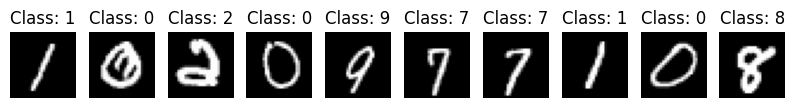

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week.
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication.

Note, like before, we consider multiple examples at once, adding another dimension to the input.


 <img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/LinearModel_1.png?raw=1"  align="center"/>



The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this week let's make two changes that make more sense for classification:
    - Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
    - Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step.

In [6]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # First, we need to convert the input image to a vector by using
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()

        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)

    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [7]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [8]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [9]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [10]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [11]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.502031925201416, accuracy: 87.63541666666667
Epoch 0: val. loss: 0.49497688862871614, val. accuracy: 87.725
Epoch 1: training loss: 0.42146141624450684, accuracy: 89.03958333333334
Epoch 1: val. loss: 0.41258512849503376, val. accuracy: 88.9
Epoch 2: training loss: 0.3874749786456426, accuracy: 89.67916666666666
Epoch 2: val. loss: 0.3779438762588704, val. accuracy: 89.5
Epoch 3: training loss: 0.36752203941345213, accuracy: 90.07916666666667
Epoch 3: val. loss: 0.35777117359511396, val. accuracy: 89.86666666666666
Epoch 4: training loss: 0.35396049853165945, accuracy: 90.43541666666667
Epoch 4: val. loss: 0.34419506201718714, val. accuracy: 90.24166666666666
CPU times: user 1min 8s, sys: 205 ms, total: 1min 8s
Wall time: 1min 10s


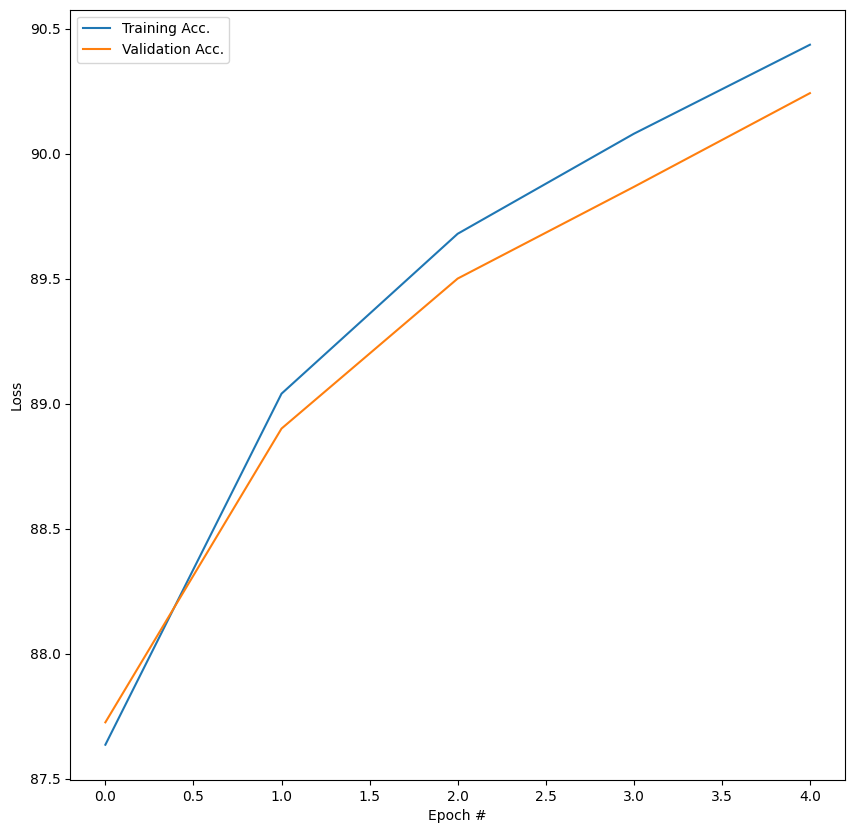

In [12]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

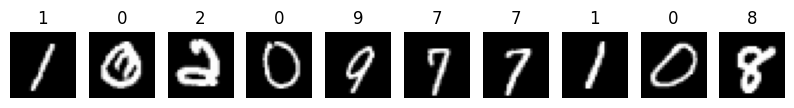

In [13]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc.

# Prediction

Let's see how our model generalizes to the unseen test data.



In [14]:
#create dataloader for test data
# The dataloader makes our dataset iterable
batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [15]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3322, test accuracy: 90.80%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [16]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the test data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


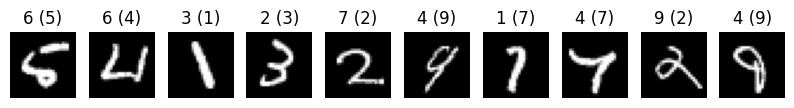

In [17]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/shallow_nn.png?raw=1"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/activation.jpeg?raw=1"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/deep_nn_annotated.jpg?raw=1"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/bias_vs_variance.png?raw=1"  align="left"/>


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/acc_under_over.webp?raw=1"  align="center"/>


To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [18]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [19]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [20]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.9325424572626749, accuracy: 73.97500000000001
Epoch 0: val. loss: 0.9265628197091691, val. accuracy: 74.26666666666667
Epoch 1: training loss: 0.4107259318828583, accuracy: 88.31875
Epoch 1: val. loss: 0.4065389221018933, val. accuracy: 88.175
Epoch 2: training loss: 0.31241252315044404, accuracy: 91.12291666666667
Epoch 2: val. loss: 0.3074884189570204, val. accuracy: 90.88333333333334
Epoch 3: training loss: 0.25938240867853163, accuracy: 92.56666666666666
Epoch 3: val. loss: 0.25513056435800613, val. accuracy: 92.25833333333333
Epoch 4: training loss: 0.21880499013264973, accuracy: 93.70833333333334
Epoch 4: val. loss: 0.21761474274891487, val. accuracy: 93.50833333333334
CPU times: user 1min 13s, sys: 227 ms, total: 1min 13s
Wall time: 1min 16s


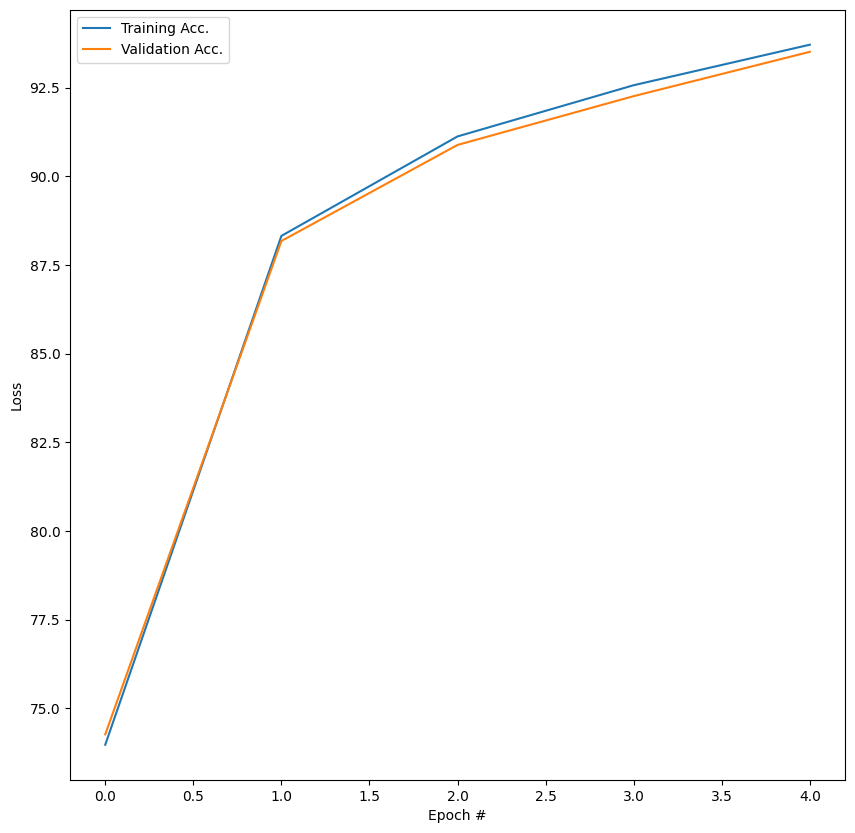

In [21]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


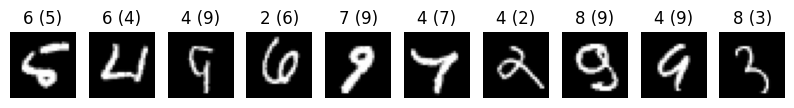

In [22]:
show_failures(nonlinear_model, test_dataloader)

# Recap
To train and validate a neural network model, you need:
- Data split into training/validation/test sets,
- A model with parameters to learn,
- An appropriate loss function,
- An optimizer (with tunable parameters such as learning rate, weight decay etc.) used to learn the parameters of the model.


# Homework

1. Compare the quality of your model when using different:
 - batch sizes,
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization.

**Effect of Batch Size on Model Quality**

In [25]:
# Define function to define, train, and run model
def train_run_model(b_size=128, learn_rate=0.05):
  batch_size = b_size

  # The dataloader makes our dataset iterable
  train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=b_size)
  val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=b_size)

  nonlinear_model = NonlinearClassifier()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=learn_rate)

  import time

  epochs = 5
  train_acc_all = []
  val_acc_all = []
  for j in range(epochs):
      train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

      # checking on the training loss and accuracy once per epoch
      acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
      train_acc_all.append(acc)
      print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

      # checking on the validation loss and accuracy once per epoch
      val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
      val_acc_all.append(val_acc)
      print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

  pltsize=1
  plt.figure(figsize=(10*pltsize, 10 * pltsize))
  plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
  plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
  plt.title(f'Batch Size = {b_size}, Learning Rate = {learn_rate}')
  plt.xlabel('Epoch #')
  plt.ylabel('Loss')
  plt.legend()

Epoch 0: training loss: 0.3524519186389322, accuracy: 89.725
Epoch 0: val. loss: 0.3442538375034928, val. accuracy: 89.65833333333333
Epoch 1: training loss: 0.22179505564272403, accuracy: 93.675
Epoch 1: val. loss: 0.2231441996525973, val. accuracy: 93.36666666666666
Epoch 2: training loss: 0.17218875869584735, accuracy: 95.025
Epoch 2: val. loss: 0.18296536600682883, val. accuracy: 94.575
Epoch 3: training loss: 0.14048582173903318, accuracy: 95.88125
Epoch 3: val. loss: 0.1527538952184841, val. accuracy: 95.55
Epoch 4: training loss: 0.12504641239744765, accuracy: 96.32708333333333
Epoch 4: val. loss: 0.1408008927013725, val. accuracy: 95.71666666666667


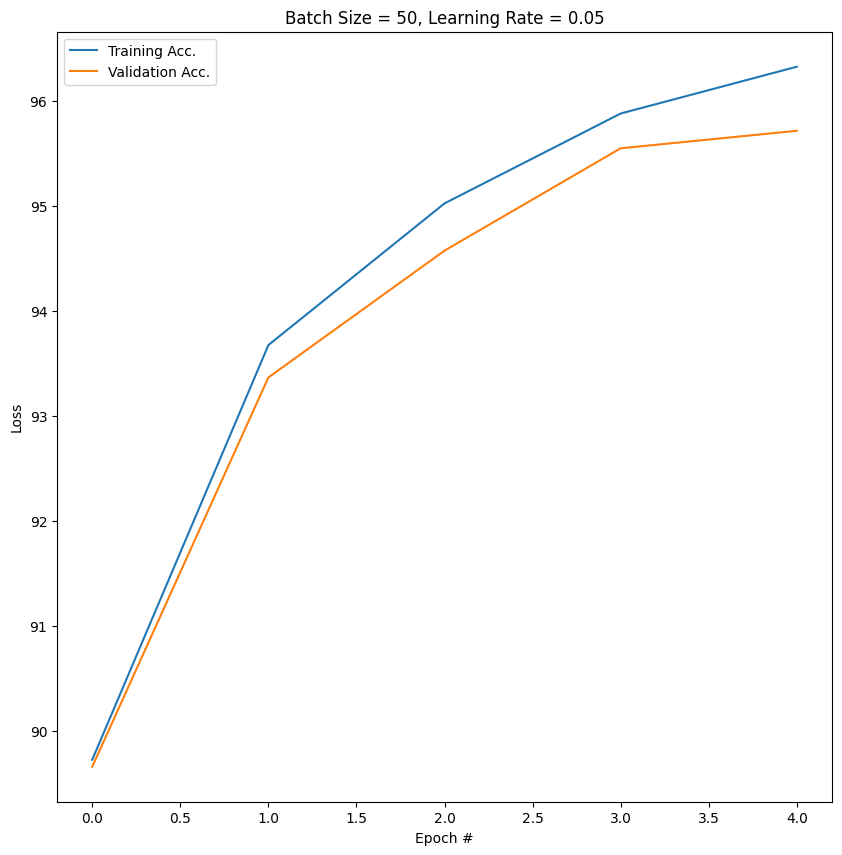

In [24]:
# Set batch size to 50
train_run_model(b_size=50)

Decreasing the batch size from 128 to 50 increased the accuracy of the model.

Epoch 0: training loss: 2.2721780935923257, accuracy: 31.791666666666668
Epoch 0: val. loss: 2.2717767457167306, val. accuracy: 32.458333333333336
Epoch 1: training loss: 2.1009829491376877, accuracy: 35.791666666666664
Epoch 1: val. loss: 2.100859065850576, val. accuracy: 35.5
Epoch 2: training loss: 1.3307794506351154, accuracy: 70.56666666666666
Epoch 2: val. loss: 1.3288684238990147, val. accuracy: 70.83333333333334
Epoch 3: training loss: 0.6917977103342613, accuracy: 81.77708333333334
Epoch 3: val. loss: 0.6854596262176832, val. accuracy: 81.83333333333334
Epoch 4: training loss: 0.5193585756545266, accuracy: 85.61041666666667
Epoch 4: val. loss: 0.5122799587746462, val. accuracy: 85.5


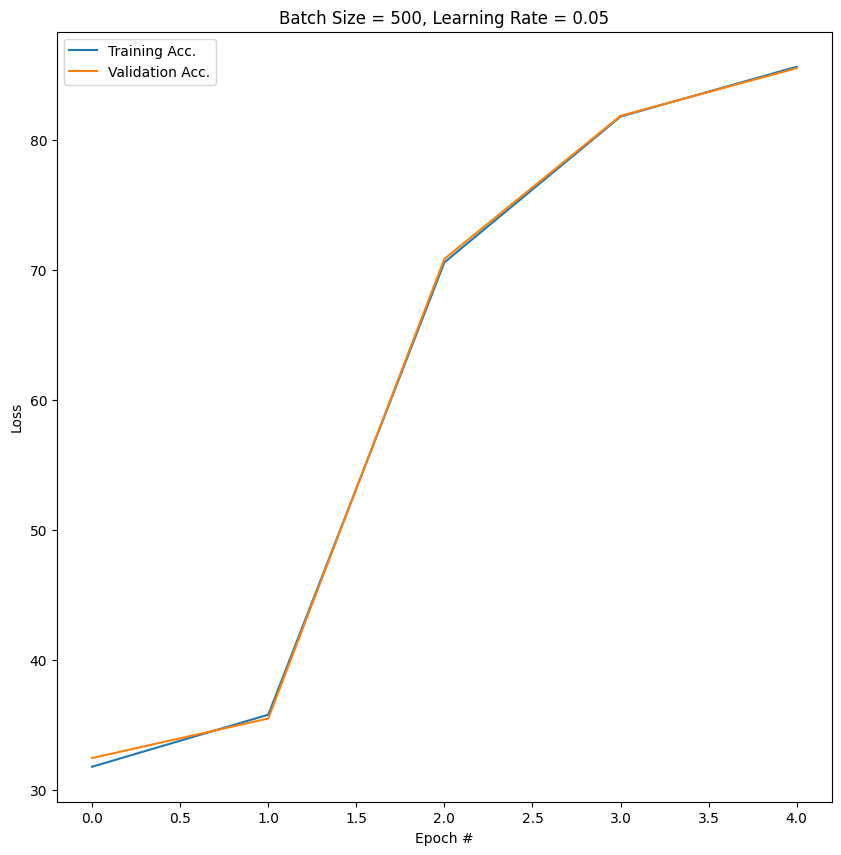

In [26]:
# Set batch size to 500
train_run_model(b_size=500)

Increasing the batch size to 500 decreases the accuracy of the model.

**Effect of Learning Rate**

Epoch 0: training loss: 2.281055290222168, accuracy: 20.991666666666667
Epoch 0: val. loss: 2.280558002755997, val. accuracy: 21.266666666666666
Epoch 1: training loss: 2.2154748407999674, accuracy: 45.427083333333336
Epoch 1: val. loss: 2.2149907401267517, val. accuracy: 45.824999999999996
Epoch 2: training loss: 1.8635426222483318, accuracy: 50.43958333333334
Epoch 2: val. loss: 1.8626736415193437, val. accuracy: 50.458333333333336
Epoch 3: training loss: 1.0807893840471903, accuracy: 71.82083333333334
Epoch 3: val. loss: 1.0760255316470533, val. accuracy: 72.41666666666666
Epoch 4: training loss: 0.6852900363604227, accuracy: 80.77499999999999
Epoch 4: val. loss: 0.6789169146659526, val. accuracy: 80.95


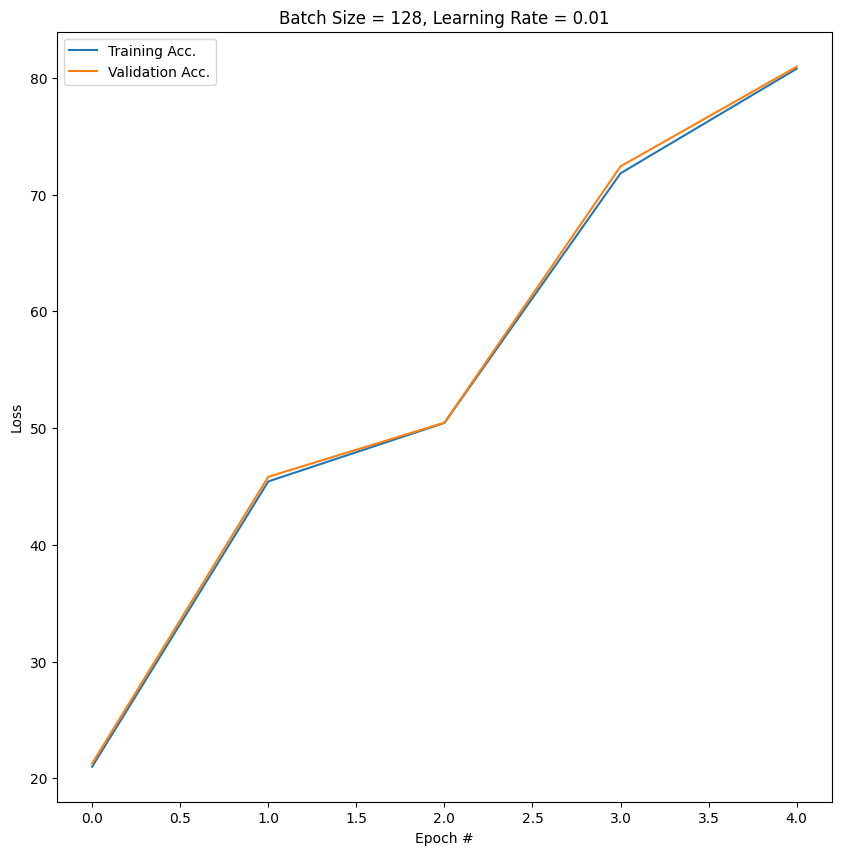

In [27]:
# Change learning rate to 0.01
train_run_model(learn_rate=0.01)

Decreasing the learning rate to 0.01 decreases the accuracy of the model.

Epoch 0: training loss: 0.5274478185971578, accuracy: 81.77916666666667
Epoch 0: val. loss: 0.5257391298704959, val. accuracy: 81.74166666666667
Epoch 1: training loss: 0.3655729347070058, accuracy: 89.65625
Epoch 1: val. loss: 0.36758630691056554, val. accuracy: 89.70833333333333
Epoch 2: training loss: 0.27321362165609997, accuracy: 91.99583333333334
Epoch 2: val. loss: 0.28037892091781536, val. accuracy: 91.68333333333332
Epoch 3: training loss: 0.23758015203475952, accuracy: 93.10000000000001
Epoch 3: val. loss: 0.24080386266429374, val. accuracy: 92.69166666666668
Epoch 4: training loss: 0.21168336300055185, accuracy: 93.89583333333333
Epoch 4: val. loss: 0.21771908480119198, val. accuracy: 93.35


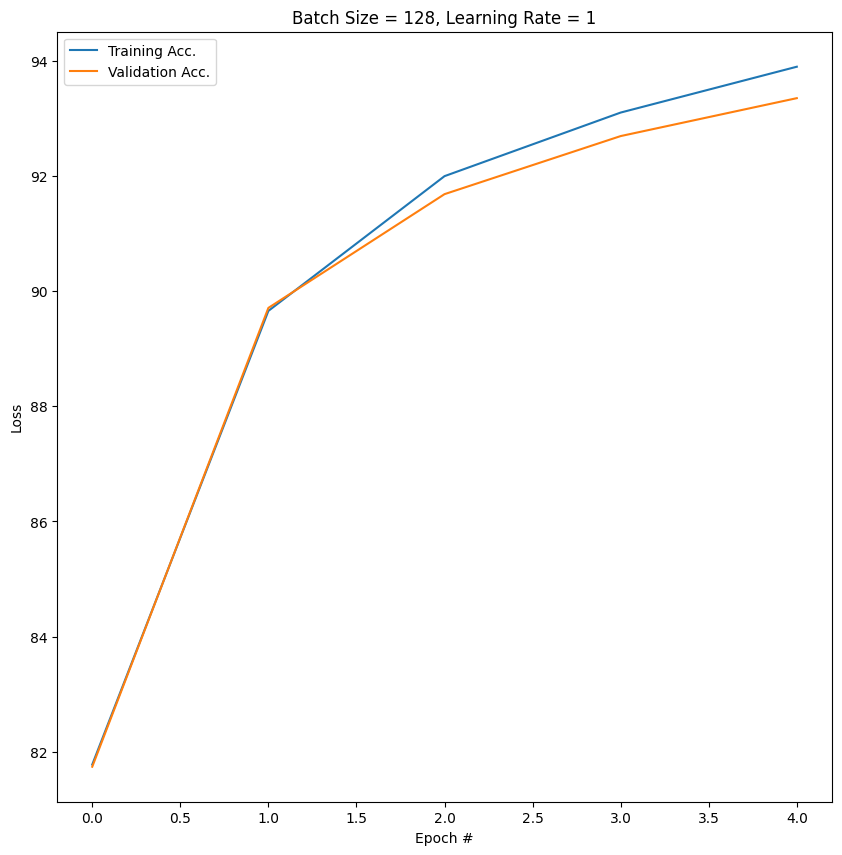

In [29]:
# Change learning rate to 1
train_run_model(learn_rate=1)

Increasing the learning rate to 1 did not change the accuracy significantly.

Epoch 0: training loss: 0.4462926555474599, accuracy: 86.02083333333333
Epoch 0: val. loss: 0.44297150855368755, val. accuracy: 85.64166666666667
Epoch 1: training loss: 0.2640305361946424, accuracy: 92.1875
Epoch 1: val. loss: 0.26464123794056, val. accuracy: 91.96666666666667
Epoch 2: training loss: 0.19957857901851336, accuracy: 94.19583333333334
Epoch 2: val. loss: 0.20400223373732668, val. accuracy: 93.8
Epoch 3: training loss: 0.16060228165984153, accuracy: 95.37708333333333
Epoch 3: val. loss: 0.16973576365791737, val. accuracy: 94.925
Epoch 4: training loss: 0.13830852769315244, accuracy: 96.03541666666666
Epoch 4: val. loss: 0.1513008247823157, val. accuracy: 95.58333333333333


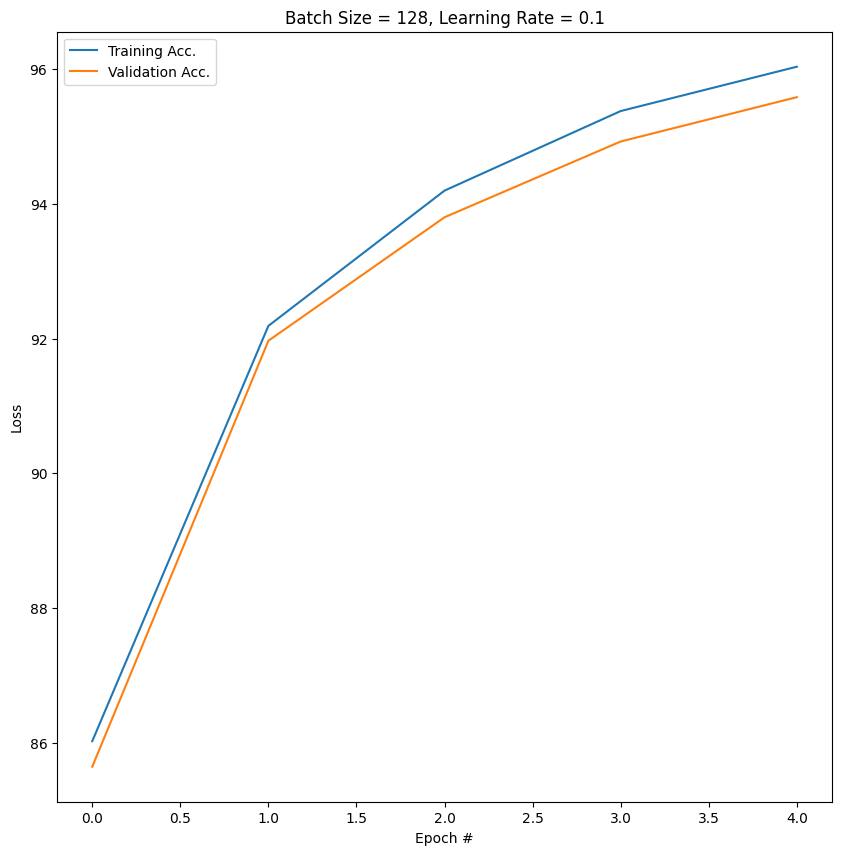

In [28]:
# Change learning rate to 0.1
train_run_model(learn_rate=0.1)

Increasing the learning rate to 0.1 increased the accuracy of the model.



**Effect of Activation Function**

In [30]:
# Change activation function to sigmoid
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Sigmoid(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

Epoch 0: training loss: 2.3021217269897463, accuracy: 11.2375
Epoch 0: val. loss: 2.302137752796741, val. accuracy: 11.233333333333333
Epoch 1: training loss: 2.301948782602946, accuracy: 11.2375
Epoch 1: val. loss: 2.3019636945521578, val. accuracy: 11.233333333333333
Epoch 2: training loss: 2.30175727335612, accuracy: 11.2375
Epoch 2: val. loss: 2.3017705399939357, val. accuracy: 11.233333333333333
Epoch 3: training loss: 2.301536766052246, accuracy: 11.2375
Epoch 3: val. loss: 2.3015477784136507, val. accuracy: 11.233333333333333
Epoch 4: training loss: 2.301278329849243, accuracy: 11.2375
Epoch 4: val. loss: 2.301286136850398, val. accuracy: 11.233333333333333


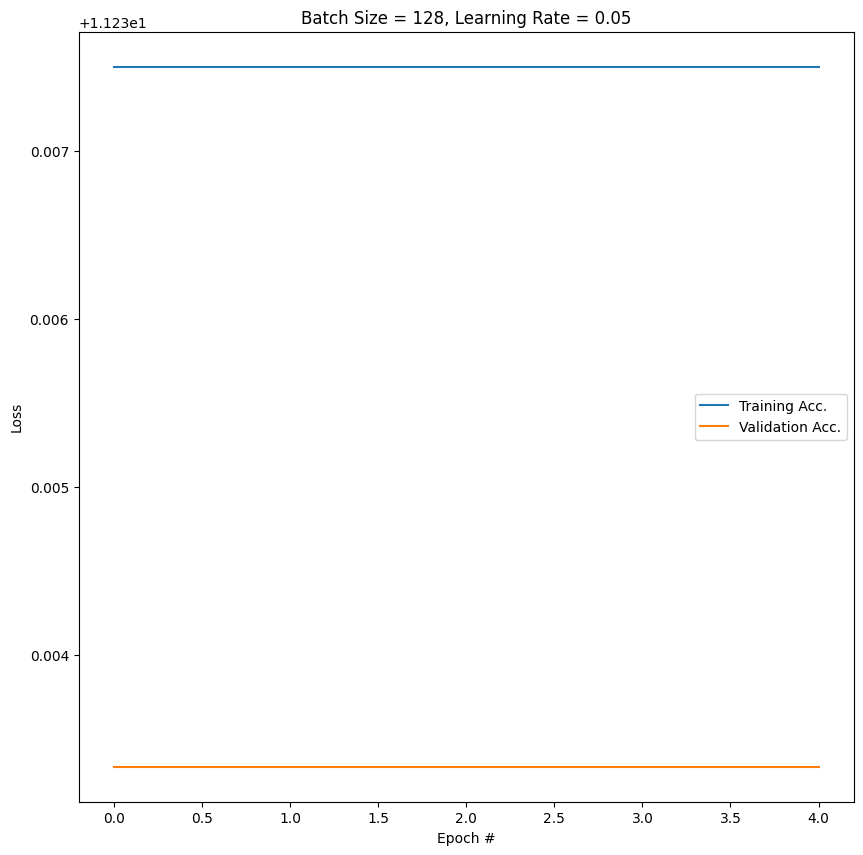

In [31]:
train_run_model()

Changing the activation function from relu to sigmoid caused the model to fail to classify the images.

In [32]:
# Change activation function to hyperbolic tan
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

Epoch 0: training loss: 0.5788974743684133, accuracy: 84.2125
Epoch 0: val. loss: 0.575255996686347, val. accuracy: 84.06666666666666
Epoch 1: training loss: 0.38624613372484845, accuracy: 89.20625
Epoch 1: val. loss: 0.3802714576112463, val. accuracy: 88.86666666666667
Epoch 2: training loss: 0.3186165776252747, accuracy: 90.99374999999999
Epoch 2: val. loss: 0.3130650504472408, val. accuracy: 90.60000000000001
Epoch 3: training loss: 0.2868811413049698, accuracy: 91.82083333333333
Epoch 3: val. loss: 0.28329379000562305, val. accuracy: 91.525
Epoch 4: training loss: 0.2636063368121783, accuracy: 92.43124999999999
Epoch 4: val. loss: 0.2613986717101107, val. accuracy: 92.10000000000001


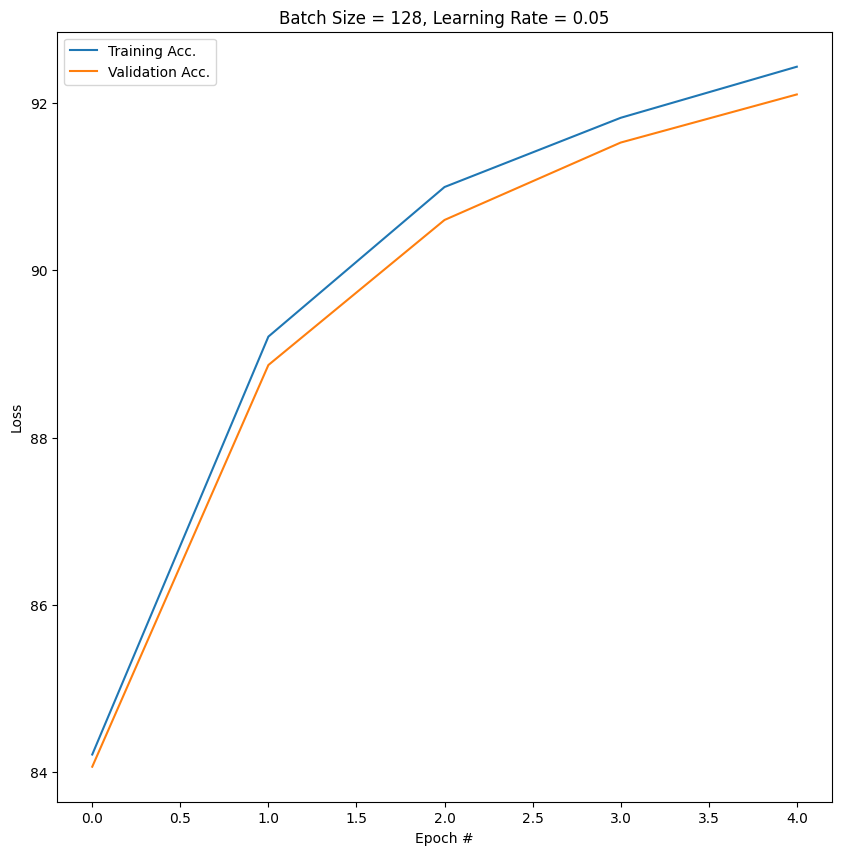

In [33]:
train_run_model()

Changing the activation function from relu to hyperbolic tan did not significantly change accuracy.

In [36]:
# Change activation function to elu
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

Epoch 0: training loss: 0.5168345855077108, accuracy: 85.16041666666668
Epoch 0: val. loss: 0.5145210966150812, val. accuracy: 85.08333333333333
Epoch 1: training loss: 0.3508738036553065, accuracy: 89.99583333333334
Epoch 1: val. loss: 0.34228197025491836, val. accuracy: 89.93333333333334
Epoch 2: training loss: 0.3011931782563527, accuracy: 91.31458333333333
Epoch 2: val. loss: 0.2923836606614133, val. accuracy: 91.07499999999999
Epoch 3: training loss: 0.2703819546699524, accuracy: 92.17291666666667
Epoch 3: val. loss: 0.264278557944171, val. accuracy: 92.01666666666667
Epoch 4: training loss: 0.24332943143447242, accuracy: 92.975
Epoch 4: val. loss: 0.23941681803540982, val. accuracy: 92.85833333333333


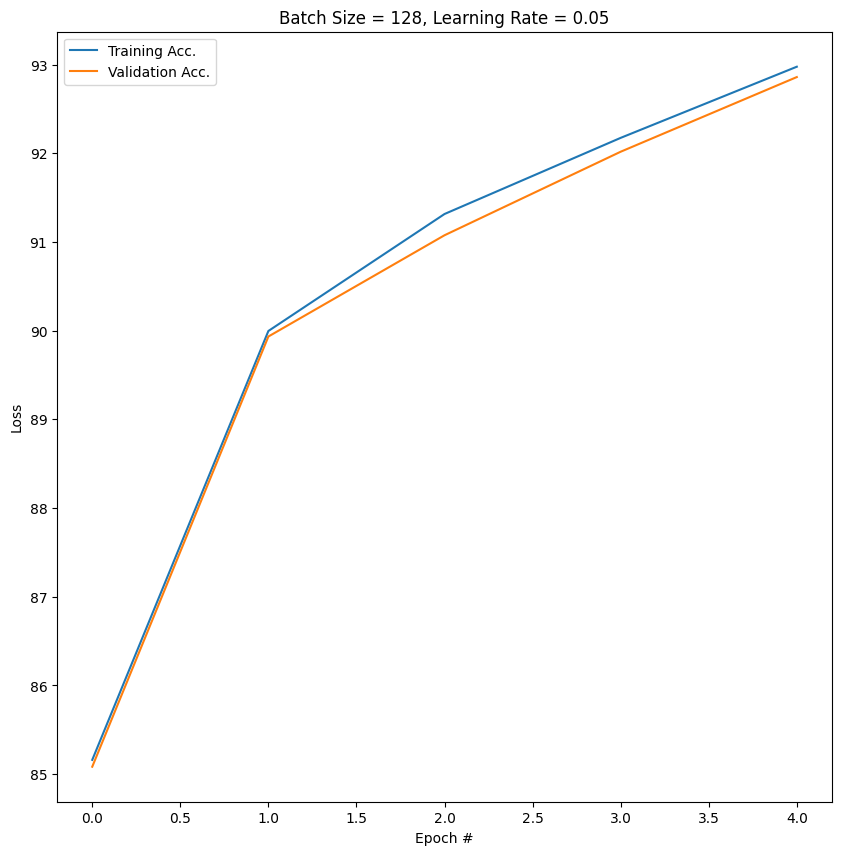

In [37]:
train_run_model()

Changing the activation function to elu did not significantly change the accuracy.

**Bonus**

A learning rate scheduler is a framework that adjusts the learning rate during the training process.